In [32]:
# Parameters
artificial_humans = "../../artifacts/artificial_humans/04_3_model/model/architecture_node+edge+rnn.pt"
artificial_humans_valid = "../../artifacts/artificial_humans/02_3_valid/model/rnn_True.pt"
managers = {
    "humanlike_governor": {
        "type": "human",
        "path": "../../artifacts/human_like_manager/05_2_model/model/architecture_node+edge.pt",
    },
    "ai_governor": {
        "type": "rl",
        "path": "../../artifacts/manager_v3/17_model3/model/architecture_node+edge+rnn__run_0.pt",
    },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 10


In [39]:
import re
import requests
import datetime
import os
import random
import numpy as np


BACKEND_URL = os.environ.get('MANAGER_BACKEND_URL', 'http://0.0.0.0:8000')


def get_punishments(contributions, missing_inputs, groups, *, session, group_idx, round):
    """
    Requests the punishments form the manger backend.

    Args:
        contributions [int]: contributions in fixed order (order has to remain throughout the game)
        missing_inputs [boolean]: missing_inputs in fixed order (same order as contributions)
        groups [str]: group identifier in fixed order (same order as contributions)
        session str: session indentifier
        subsession str: subsession identifier
        round int: round number

    Returns:
        [int]: punishments for each player in the same order then contributions
    """
    data = {
        'contributions': contributions,
        'missing_inputs': missing_inputs,
        'groups': groups,
        'round': round,
        'group_idx': group_idx,
        'session': session,
        'datetime': str(datetime.datetime.now())
    }
    url = BACKEND_URL + '/get_punishments'
    response = requests.post(url, json={'data': data}).json()
    return response
    # return {'data': {**data, 'punishments': [0]*len(contributions)}}


In [40]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.artificial_humans import GraphNetwork
from aimanager.manager.manager import ArtificalManager

from aimanager.utils.array_to_df import using_multiindex, add_labels

from aimanager.manager.api_manager import MultiManager


output_path = os.path.join(output_path, 'data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)
artifical_humans_valid = GraphNetwork.load(artificial_humans_valid, device=device)


artifical_humans = GraphNetwork.load(artificial_humans, device=device)

groups = ['humanlike_governor'] * 4 + ['ai_governor'] * 4
is_hm = th.tensor([g == 'humanlike_governor' for g in groups])
n_agents = len(groups)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, artifical_humans_valid=artifical_humans_valid,
    n_agents=n_agents, n_contributions=21, n_punishments=31, 
    n_rounds=n_episode_steps, batch_size=1, device=device)

mm = MultiManager(managers)


session = str(random.randint(0, 1000000))
missing_inputs = [False] * n_agents

recorder = Memory(n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)

for e in range(n_episodes):
    # if not e%(n_episodes//20):
    #     print(f"episode {e}")

    state = env.reset()

    rounds = []
    for round_number in count():

        contributions = state['contributions'].squeeze().tolist()
        response = get_punishments(
            contributions, missing_inputs, groups, session=session, group_idx=e, round=round_number)
        round = {**response['data'], 'manager_missing_inputs': [False]*n_agents}
        backend_action = th.tensor(response['data']['punishments'], dtype=th.int64).unsqueeze(-1)

        reference_action = mm.get_punishments(rounds+[round])[0]
        rounds.append({**round, 'punishments': reference_action})
        reference_action = th.tensor(reference_action, dtype=th.int64)

        state = env.punish(backend_action)

        recorder.add(
            **{k: v.squeeze(-1) for k, v in state.items()}, 
            reference_punishment=reference_action,
            episode_step=round_number)
        state, reward, done = env.step()
        if done:
            break
    recorder.next_episode(e)

In [42]:
columns = ['episode', 'round_number','participant_code']

punishments = using_multiindex(recorder.memory['punishments'].numpy(), columns=columns, value_name='punishment')
reference_punishment = using_multiindex(recorder.memory['reference_punishment'].numpy(), columns=columns, value_name='reference_punishment')
common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=columns, value_name='contribution')

df_sim = punishments.merge(common_good).merge(contributions).merge(reference_punishment)
df_sim['p_diff_reference'] = df_sim['punishment'] - df_sim['reference_punishment']

df_sim['data_source'] = 'simulation'

columns = ['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'data_source']

df_sim['group'] = df_sim['participant_code'].map({k:v for k,v in enumerate(groups)})


df = pd.concat([df_sim]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source', 'group'], 
    value_vars=['punishment', 'contribution', 'p_diff_reference', 'reference_punishment'])

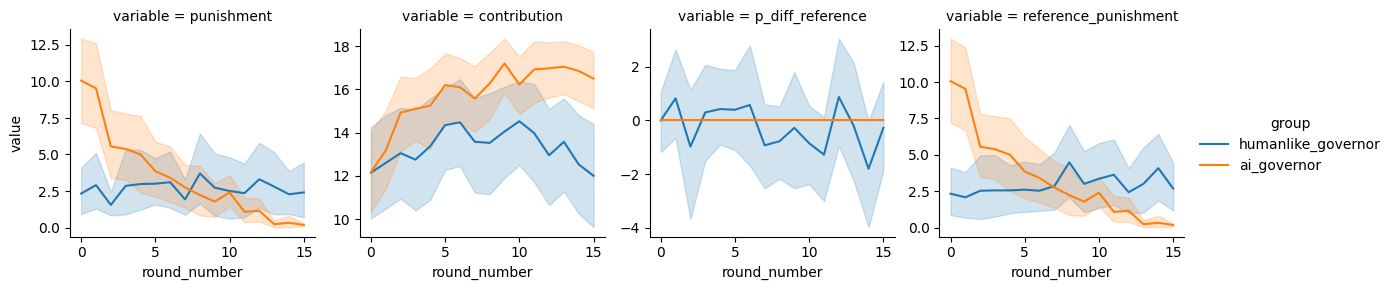

In [43]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    hue='group',
    col='variable',
    kind="line",
    height=3, aspect=1, facet_kws={'sharey': False, 'sharex': True}
)

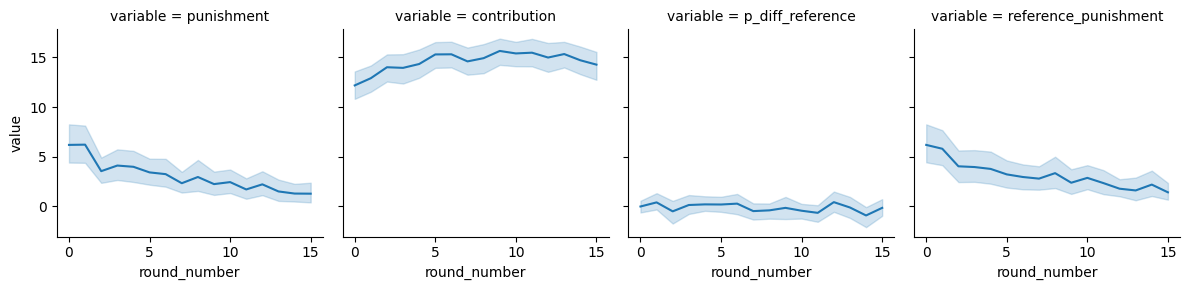

In [44]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    kind="line",
    height=3, aspect=1,
)